In [1]:
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import skimage.io as io
import skimage.exposure as exposure
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray

In [2]:
labels = []
with open('../data/menu_match_dataset/labels.txt') as f:
    content = f.read()
for l in content.splitlines():
    split_line = l.split(';')
    name = split_line[0]
    lab = split_line[1:]
    lab.remove('')
    d = {'image_name': name}
    for i in range(len(lab)):
        d["label_" + str(i + 1)] = lab[i]
    d["num_labels"] = len(lab)
    labels.append(d)

In [3]:
df = json_normalize(labels)

In [4]:
len(df)

646

In [5]:
# Maximum number of labels
print("Max number of labels: {}".format(max(df['num_labels'])))

Max number of labels: 4


In [6]:
df.head(1)

,image_name,label_1,label_2,label_3,label_4,num_labels
0,img1.jpg,pineapple_pizza,NaN,NaN,NaN,1


In [7]:
unique_categories = pd.unique(df[['label_1', 'label_2', 'label_3', 'label_4']].values.ravel())

In [10]:
unique_categories

array([' pineapple_pizza', nan, ' ginger_chicken', ' jasmine_rice',
       ' mapo_tofu', ' brown_rice', ' panang_curry_chicken',
       ' vegetable_spring_roll', ' orange_chicken', ' cashew_chicken',
       ' stirfry_beef', ' spicy_string_beans',
       ' spinach_red_curry_with_tofu', ' sweet_and_sour_vegetables',
       ' spicy_chicken_with_basil', ' stir-fry_garlic_soba_noodles',
       ' ciabatta', ' lobster_bisque_soup', ' potato_bread',
       ' whole_wheat_bread', ' olivera_bread', ' corn_bread',
       ' chicken_coconut_curry', ' classic_chili',
       ' cream_of_chicken_soup', ' vegetarian_lentils_soup',
       ' creamy_tomato_basil_soup', ' market_vegetables_soup',
       ' creamy_mushroom_soup', ' brocolli_cheddar_soup',
       ' chicken_noodle_soup', ' combo_supreme', ' cheese_pizza',
       ' bread_sticks', ' vegetarian_pizza', ' chicken_alfredo',
       ' pepperoni_pizza', ' meat_lasagna', ' yellow_curry_with_chicken',
       ' side_salad', ' vegetarian_lasagna', ' meatlov

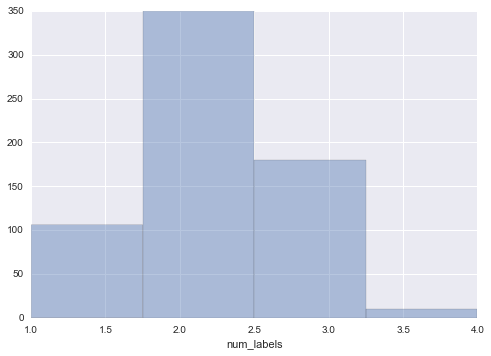

In [11]:
# Histogram of labels
sns.distplot(df['num_labels'], kde=False, bins=4);

In [12]:
df.groupby('label_1').size().sort_values(ascending=False).head(5)

label_1
 brown_rice         172
 jasmine_rice       130
 cheese_pizza        43
 bread_sticks        34
 pineapple_pizza     32
dtype: int64

In [13]:
df.groupby('label_2').size().sort_values(ascending=False).head(5)

label_2
 panang_curry_chicken    114
 orange_chicken           57
 pepperoni_pizza          34
 potato_bread             32
 jasmine_rice             31
dtype: int64

In [14]:
df.groupby('label_3').size().sort_values(ascending=False).head(5)

label_3
 spicy_string_beans           41
 panang_curry_chicken         36
 yellow_curry_with_chicken    21
 stirfry_beef                 21
 vegetable_spring_roll        18
dtype: int64

In [15]:
df.groupby('label_4').size().sort_values(ascending=False).head(5)

label_4
 vegetable_spring_roll          7
 yellow_curry_with_chicken      1
 stirfry_beef                   1
 spinach_red_curry_with_tofu    1
dtype: int64

In [16]:
all_labels = df[['image_name','label_1']].rename_axis({"image_name": "image_name", "label_1": "label"}, axis="columns")
all_labels = all_labels.append(df[['image_name','label_2']].rename_axis({"image_name": "image_name", "label_2": "label"}, axis="columns"))
all_labels = all_labels.append(df[['image_name','label_3']].rename_axis({"image_name": "image_name", "label_3": "label"}, axis="columns"))
all_labels = all_labels.append(df[['image_name','label_4']].rename_axis({"image_name": "image_name", "label_4": "label"}, axis="columns"))

In [17]:
print("In total there are {:,} labelled items".format(len(all_labels)))

In total there are 2,584 labelled items


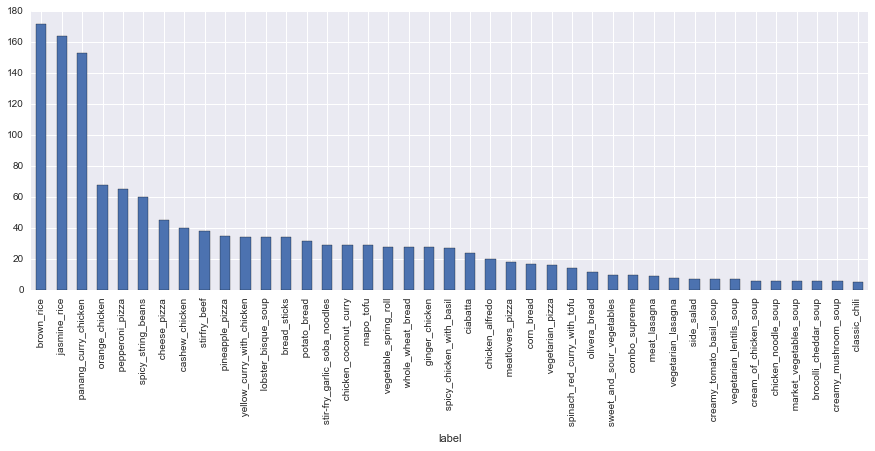

In [18]:
# Look at all labels
all_labels.groupby('label').size().sort_values(ascending=False).plot(kind='bar', figsize=(15,5));

In [19]:
df = df.fillna('')

In [20]:
# Chicken, pizza, rice, soup, bread (including ciabatta, lasagne, salad)
def is_type(t,l):
    """
    Searches for string in list of strings
    t: string to search for (in this case type of food)
    l: list of strings (in this case list of different labels)
    returns: 1 if string is present in at least one memeber of list, otherwise 0
    """
    for i in (range(len(l))):
        if re.search(t, l[i]):
            return 1
    return 0

def is_bread(l):
    """
    Confirms if a set of labels contains bread, which can be represented in different ways
    l: list of labels
    return: 1 if bread present, otherwise 0
    """
    for i in (range(len(l))):
        if re.search(r'bread|ciabatta', l[i]):
            return 1
    return 0

In [21]:
df['pizza'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('pizza',row), axis=1)
df['chicken'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('chicken',row), axis=1)
df['rice'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('rice',row), axis=1)
df['soup'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('soup',row), axis=1)
df['lasagne'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('lasagne',row), axis=1)
df['salad'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('salad',row), axis=1)
df['bread'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_bread(row), axis=1)

In [22]:
#Distribution of image sizes
images = []
for i in df['image_name']:
    images.append([i, io.imread('../data/menu_match_dataset/foodimages/' + i)])

In [23]:
sizes = []
for im in images:
    sizes.append({'image_name': im[0], 'image_shape': im[1].shape, 'data_type': im[1].dtype})

In [24]:
df = df.merge(pd.DataFrame.from_dict(sizes))

In [25]:
df.head(1)

,image_name,label_1,label_2,label_3,label_4,num_labels,pizza,chicken,rice,soup,lasagne,salad,bread,data_type,image_shape
0,img1.jpg,pineapple_pizza,,,,1,1,0,0,0,0,0,0,uint8,"(1000, 1776, 3)"


In [34]:
def rotate_shape(shape):
    if shape[1] > shape[0]:
        new_shape = (shape[1], shape[0], shape[2])
        return new_shape
    else:
        return shape

In [35]:
df['rotated_shape'] = df['image_shape'].apply(rotate_shape)

In [36]:
df.head(10)

,image_name,label_1,label_2,label_3,label_4,num_labels,pizza,chicken,rice,soup,lasagne,salad,bread,data_type,image_shape,rotated_shape
0,img1.jpg,pineapple_pizza,,,,1,1,0,0,0,0,0,0,uint8,"(1000, 1776, 3)","(1776, 1000, 3)"
1,img2.jpg,ginger_chicken,jasmine_rice,mapo_tofu,,3,0,1,1,0,0,0,0,uint8,"(1000, 1776, 3)","(1776, 1000, 3)"
2,img3.jpg,brown_rice,panang_curry_chicken,vegetable_spring_roll,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
3,img4.jpg,jasmine_rice,orange_chicken,,,2,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
4,img5.jpg,jasmine_rice,orange_chicken,panang_curry_chicken,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
5,img6.jpg,jasmine_rice,mapo_tofu,panang_curry_chicken,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
6,img7.jpg,cashew_chicken,jasmine_rice,orange_chicken,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
7,img8.jpg,cashew_chicken,jasmine_rice,panang_curry_chicken,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
8,img9.jpg,brown_rice,panang_curry_chicken,stirfry_beef,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"
9,img10.jpg,brown_rice,orange_chicken,stirfry_beef,,3,0,1,1,0,0,0,0,uint8,"(1632, 1224, 3)","(1632, 1224, 3)"


In [38]:
sizes = df['rotated_shape'].unique()
len(sizes)

44

In [39]:
df.groupby('image_shape').size().sort_values(ascending=False)

image_shape
(1000, 1776, 3)    145
(1632, 1224, 3)    121
(1500, 2000, 3)    115
(1224, 1632, 3)     67
(1776, 1000, 3)     48
(864, 1536, 3)      31
(1632, 920, 3)      27
(1296, 968, 3)      18
(1536, 864, 3)      12
(920, 1632, 3)      12
(968, 1296, 3)      11
(600, 991, 3)        2
(683, 998, 3)        1
(678, 994, 3)        1
(721, 994, 3)        1
(696, 996, 3)        1
(640, 987, 3)        1
(721, 996, 3)        1
(674, 991, 3)        1
(629, 978, 3)        1
(638, 998, 3)        1
(638, 971, 3)        1
(633, 996, 3)        1
(766, 987, 3)        1
(625, 985, 3)        1
(620, 978, 3)        1
(613, 985, 3)        1
(586, 994, 3)        1
(753, 989, 3)        1
(831, 980, 3)        1
(768, 976, 3)        1
(928, 991, 3)        1
(1186, 996, 3)       1
(1029, 976, 3)       1
(1011, 978, 3)       1
(992, 825, 3)        1
(955, 985, 3)        1
(950, 973, 3)        1
(940, 973, 3)        1
(917, 996, 3)        1
(786, 985, 3)        1
(914, 991, 3)        1
(905, 976, 3)        1

In [40]:
df['X'] = df['image_shape'].apply(lambda x: x[0])
df['Y'] = df['image_shape'].apply(lambda x: x[1])

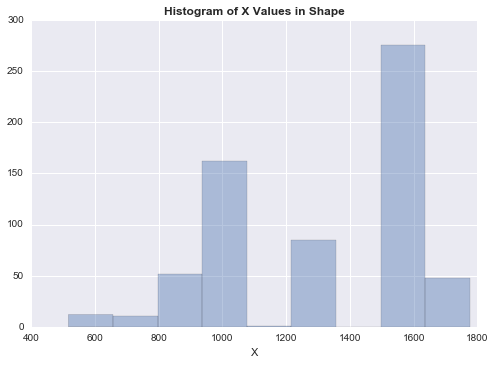

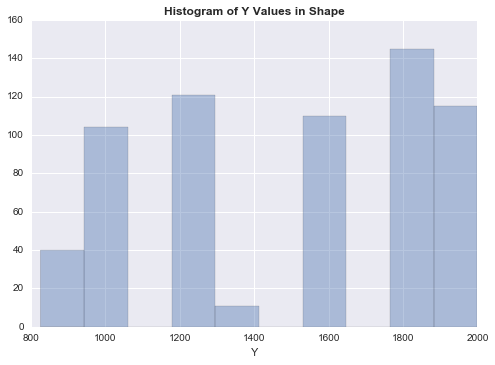

In [41]:
#X Values
ax = sns.distplot(df['X'], kde=False)
ax.set_title("Histogram of X Values in Shape", weight="bold")
plt.show()

#Y Values
ax = sns.distplot(df['Y'], kde=False)
ax.set_title("Histogram of Y Values in Shape", weight="bold")
plt.show()

In [42]:
df.groupby('data_type').size()

data_type
uint8    646
dtype: int64

In [43]:
single_class = df[df['num_labels'] == 1]

In [44]:
print("There are {} images with just one label".format(len(single_class)))

There are 106 images with just one label


In [45]:
single_class.groupby('label_1').size().sort_values(ascending=False)

label_1
 pepperoni_pizza       29
 cheese_pizza          26
 pineapple_pizza       16
 meatlovers_pizza      11
 chicken_alfredo        6
 vegetarian_pizza       5
 combo_supreme          5
 vegetarian_lasagna     3
 whole_wheat_bread      1
 stirfry_beef           1
 side_salad             1
 meat_lasagna           1
 brown_rice             1
dtype: int64

In [665]:
df.to_csv('../data/menu_match_dataset/basic_info.csv', index=False)